## Overview & Usage of the Tensorflow Quant Library 
### Import all the good stuff & create shortcuts

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Import for Tensorflow Quant Finance
import tf_quant_finance as tff 
 
# Shortcut alias
pde = tff.math.pde
option_price = tff.black_scholes.option_price
implied_vol = tff.black_scholes.implied_vol


#### Things to note:
- Tensorflow allocates around 95% of the GPU memory by default on memory initialisation. So nothing to worry about.
- GPU implementation is around 3x+ faster than CPU (if not default, run it `with tf.device("/gpu:0"):`)
- Running `tf.keras.backend.clear_session()` can solve some bugs within the notebook 
- Per AK using runs of 50k samples is a good starting point for MC

### Price BTC option with closed form solution
Can do multiple options by extending the arrays.

In [3]:
forwards = np.array([31600])
strikes = np.array([32000])
expiries = np.array([0.5])
volatilities = np.array([0.65])
discount_factors = 1
is_call_options = np.array([True])

# Price option using market data specified above
out_prices = option_price(
      volatilities=volatilities,
      strikes=strikes/forwards,
      expiries=expiries,
      forwards=forwards/forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options).numpy() * forwards

# Reversing the Option price to back out IV
prices = np.array([5582])

out_ivs = implied_vol(
    prices=prices/forwards,
    strikes=strikes/forwards,
    expiries=expiries,
    forwards=forwards/forwards,
    validate_args=False,
    tolerance=1e-8,
    max_iterations=1000).numpy()

out_prices, out_ivs

(array([5582.10591316]), array([0.64998787]))

### Query Bastion Volsurface and format it properly
- Can specify the ranges and have to update timestamp `valuation_date` for it to work properly 

In [4]:
# RestClient
"""
    This module implements the FtxClient class and enables interaction with the FTX exchange.
"""

import time
import urllib.parse
from typing import Optional, Dict, Any

import hmac
import json
import requests

class RestClient:
    def __init__(self, api_url, api_key=None, api_secret=None, subaccount_name=None) -> None:
        self.API_URL = api_url
        self._api_key = api_key
        self._api_secret = api_secret
        self._subaccount_name = subaccount_name

    def _get(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('GET', path, params=params)

    def _post(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('POST', path, payload=params)

    def _delete(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('DELETE', path, payload=params)

    def _request(self, method: str, endpoint: str, auth: bool = True, params={}, payload={}, api=None):
        for count in range(1,4):
            try:
                _payload = json.dumps(payload) if payload else ''
                _endpoint=f'{endpoint}?{urllib.parse.urlencode(params, safe="/")}' if params else _endpoint
                if not api:
                    api = self.API_URL

                url = f'{api}{_endpoint}'

                header = {}
                if method == 'GET':
                    response = requests.get(url, headers=header, timeout=3)
                elif method == 'POST':
                    response = requests.post(url, data=_payload, headers=header, timeout=3)
                elif method == 'DELETE':
                    response = requests.delete(url, data=_payload, headers=header, timeout=3)

                data = response.json()
                response.close()
                return data
            except ConnectionError as err:
                time.sleep(0.5*count)
            except Exception as err:
                time.sleep(0.5*count)

    def _generate_signature(self, timestamp: str, method: str, endpoint: str, data='') -> dict:
        message = f'{timestamp}{method}{endpoint}{data}'
        signature = hmac.new(self._api_secret.encode('utf-8'), message.encode('utf-8'), 'sha256').hexdigest()
        return signature

    def get_endpoint(self, endpoint, params={}):
        return self._get(endpoint, params)

    def post_endpoint(self, endpoint, params={}):
        return self._post(endpoint, params)

client = RestClient("https://defi-bot.bastioncb.com:1443/")


In [54]:
# 1. Feed Volatility surface using a processed_market_data.VolatilitySurface instance
import datetime
from tf_quant_finance.experimental.pricing_platform.framework.market_data.volatility_surface import VolatilitySurface

SPOT_REF = 31600
DAY_REF = datetime.date(2022, 6, 8) #YYYY-MM-DD

# Construct tff native Datetensors
valuation_date = tff.datetime.dates_from_datetimes([DAY_REF])
dates = [DAY_REF + datetime.timedelta(days=i) for i in range(1, 30*6+15)]

# SET expiries as a (1 x Maturities) tensor 
expiries = tff.datetime.dates_from_datetimes(dates).reshape((1,-1))

# Construct the strike space
dk = 500
S = [15000 + dk*i for i in range(45000//dk)]

# Obtain IVs from volsurface
date_strings = ",".join([date.strftime('%d%b%y').upper() for date in dates])
strikes_strings = ",".join([str(strike) for strike in S])
params =  {"symbols": "BTC", "maturities": date_strings, "strikes": strikes_strings}

# dict: { maturity: {price: iv, ... }, ... }
response = client.get_endpoint('volsurface', params)

# New addition
# SET strikes as (1 x Maturities x Strikes) tensor
strikes = np.array(S)
strikes = [expiries.shape[1]*[strikes.tolist()]]
strikes = tf.constant(strikes, dtype=tf.float64)
#strikes = tf.math.log(strikes)

input_vols = pd.DataFrame(response).to_numpy().T.reshape((1, strikes.shape[1], -1))

expiry_times = tff.datetime.daycount_actual_365_fixed(start_date=valuation_date, end_date=expiries, dtype=tf.float64)

def build_volatility_surface(val_date, expiry_times, expiries, strikes, iv, dtype):
  interpolator = tff.math.interpolation.interpolation_2d.Interpolation2D(expiry_times, strikes, iv, dtype=dtype)
  
  def _interpolator(t, x):
    x_transposed = tf.transpose(x)
    t = tf.broadcast_to(t, x_transposed.shape)
    return tf.transpose(interpolator.interpolate(t, x_transposed))

  return VolatilitySurface(val_date, expiries, strikes, iv, interpolator=_interpolator, dtype=dtype)

# Test that it returns the right surface
volsurface = build_volatility_surface(valuation_date, expiry_times, expiries, strikes, input_vols, dtype=tf.float64)

# Test that it works with dates
print(volsurface.volatility(strike=np.array([[40000]]), 
                            expiry_dates=tff.datetime.dates_from_datetimes([datetime.date(2022, 9, 1)]).reshape((1,-1))))

# Test that it works with time
print(volsurface.volatility(strike=np.array([[32100]]), 
                            expiry_times=np.array([[1/12]])))
print("Lower limit:", volsurface.volatility(strike=np.array([[0]]), 
                            expiry_times=np.array([[1/12]])).numpy())
print("Upper limit:", volsurface.volatility(strike=np.array([[100000]]), 
                            expiry_times=np.array([[1/12]])).numpy())


tf.Tensor([[0.6041501]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.60650176]], shape=(1, 1), dtype=float64)
Lower limit: [[1.09516967]]
Upper limit: [[0.64156603]]


### Check that the volsurface looks legit

90 (194,) (194, 90) (194, 90) (194, 90)


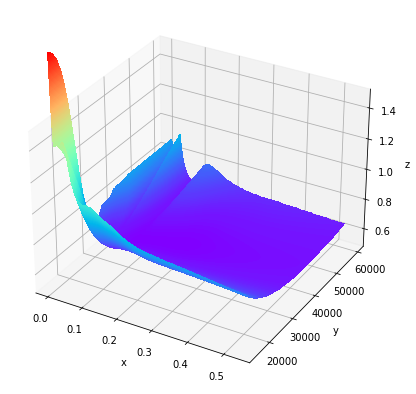

In [55]:
import plotly.graph_objects as go
t = expiry_times.numpy().reshape(-1)
zz = input_vols.reshape((-1, len(S)))
xx, yy = np.meshgrid(S, t)

plt.figure(figsize=(8,7))
ax = plt.axes(projection='3d')
print(len(S), t.shape, xx.shape, yy.shape, zz.shape)
ax.contourf3D(yy, xx, zz, 300, cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(0.5, 1.5)
plt.show()

### Example investigation: Extract the dupire local vol model from codebase

In [7]:
# Dupire implemented using van der Kamp implementation as follows: 
# --> See corresponding TF_Dupire_Implementation pdf
# Absolute K should be fine
def dupire():
  
  theta = _implied_vol(time, spot_price)
  
  d1 = tf.math.divide_no_nan(
      (tf.math.log(initial_spot_price / spot_price) +
       (risk_free_rate - dividend_yield + 0.5 * theta**2) * time) / theta,
      
      tf.math.sqrt(time))

  spot_fn = lambda x: _implied_vol(time, x)
  time_fn = lambda t: _implied_vol(t, spot_price)
  # Computes the gradients 
  dtheta_dt = lambda t: math.fwd_gradient(time_fn, t)
  dtheta_dspot = lambda x: math.fwd_gradient(spot_fn, x)
  # Computes the second deriv.
  d2theta_dspot2 = lambda x: math.fwd_gradient(dtheta_dspot, x)
  
  numerator = (
      theta**2 + 2 * time * theta * dtheta_dt(time) + 2 *
      (risk_free_rate - dividend_yield) * spot_price * time * theta *
      dtheta_dspot(spot_price))
  
  denominator = (
      (1 + spot_price * d1 * time * dtheta_dspot(spot_price))**2 +
      spot_price**2 * time * theta *
      (d2theta_dspot2(spot_price) - d1 * time * dtheta_dspot(spot_price)**2))
  
  local_volatility_squared = tf.nn.relu(tf.math.divide_no_nan(numerator, denominator))
  
  

In [24]:
from tf_quant_finance.experimental.local_volatility import local_volatility_model

dupire_local_volatility = local_volatility_model._dupire_local_volatility_iv

# Query specific times and spots 
# if times.shape > spots.shape => ERROR (?)
times = tf.convert_to_tensor([1/12], dtype=tf.float64)
spots = tf.reshape(tf.convert_to_tensor([30000, 32000, 33000], dtype=tf.float64), [-1, 1])

# Should remain constant
initial_spot = tf.constant([[31600]], dtype=tf.float64)
discount_factor_fn = lambda t: tf.math.exp(-0 * t)
dividend_yield = [0.]

# Looks like all the spot/strike inputs in non-log terms
# -> Double checks 
# Query function
dupire_local_volatility(times, 
                        spots, 
                        initial_spot, 
                        volsurface.volatility, 
                        discount_factor_fn, 
                        dividend_yield)

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[0.58555009],
       [0.56978833],
       [0.56647748]])>

### MC pricing of a vanilla option with custom vol and drift model

The Euler-Scheme is implemented in tf (reproduced below) in terms of $\log S_t = \log S_{t-1} + dt * drift + dW * vol$.

In [169]:
# Euler Sampling implementation


def _euler_step(*, i, written_count, current_state,
                drift_fn, volatility_fn, wiener_mean,
                num_samples, times, dt, sqrt_dt, keep_mask,
                random_type, seed, normal_draws, result,
                record_samples):
  """Performs one step of Euler scheme."""
  current_time = times[i + 1]
  written_count = tf.cast(written_count, tf.int32)
  if normal_draws is not None:
    dw = normal_draws[i]
  else:
    dw = random.mv_normal_sample(
        (num_samples,), mean=wiener_mean, random_type=random_type,
        seed=seed)
    
  dw = dw * sqrt_dt[i]
  dt_inc = dt[i] * drift_fn(current_time, current_state)  # pylint: disable=not-callable
  dw_inc = tf.linalg.matvec(volatility_fn(current_time, current_state), dw)  # pylint: disable=not-callable
  
  next_state = current_state + dt_inc + dw_inc
  
  if record_samples:
    result = result.write(written_count, next_state)
  else:
    result = next_state
  written_count += tf.cast(keep_mask[i + 1], dtype=tf.int32)

  return i + 1, written_count, next_state, result

Set parameters for comparison:

In [37]:
# Parameters Specification
dtype = np.float64  
num_samples = 50000

num_timesteps = 100

expiries = [1/12, 4/12, 6/12, 1] # This can be a rank 1 Tensor
dt = 1. / num_timesteps
rate = tf.constant(0, dtype=dtype)
sigma = tf.constant(0.65, dtype=dtype)
spot = tf.constant(SPOT_REF, dtype=dtype)

strikes = tf.constant([30000, 32000, 34000], dtype=dtype)

In [43]:
# Default Vanilla MC with BS vols

def set_up_pricer(expiries):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        
        # Can modify to include a different drift model
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        
        # Can modify to include a different vol model
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        
        # Use GenericItoProcess class to set up the general Ito process
        # dX_i = a_i(t, X) dt + Sum(S_{ij}(t, X) dW_j for 1 <= j <= n), 1 <= i <= n
        # 
        # a_i is referred to as the drift
        # b_{ij} as the volatility of the process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        
        log_spot = tf.math.log(tf.reduce_mean(spot))
        
        # Uses Euler Sampling in the backend 
        # HAS to be using log(spot)
        paths = process.sample_paths(
            expiries, 
            num_samples=num_samples,
            initial_state=log_spot, 
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        
        # Prices determined by the payoff of the option given the performance of the underlying 
        # reduce_mean -> Mean() across specified axis
        # relu -> max(x, 0)
        # exp(paths) -> paths in log prices, so exp(paths) in paths
        # strikes -> absolute terms 
        
        prices = (tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        
        # prices = (tf.exp(-tf.expand_dims(rate * expiries, axis=-1))
        #           * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        
        return prices
      
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(expiries))

print("Maturity x Strike:")
price_eu_options(strikes, spot, sigma).numpy()

Maturity x Strike:


array([[3162.25545296, 2154.8313328 , 1409.52695473],
       [5414.60487158, 4523.16456515, 3761.7201174 ],
       [6467.37185015, 5613.50168157, 4866.73519058],
       [8671.27392348, 7902.19095743, 7207.3766808 ]])

### Integrate local vol model into the MC solver 

1. Feed Volatility surface using a processed_market_data.VolatilitySurface instance
2. Initialise it in pricing_platform\framework\market_data\volatility_surface.py -> VolatilitySurface()
3. Initialise LocalVolatilityModel.from_volatility_surface()
4. Feed LocalVolatilityModel.local_volatility_fn()


In [45]:
# Volmodel Implementation 
from tf_quant_finance.experimental.local_volatility import LocalVolatilityModel

def set_up_pricer(expiries):
    """Set up European option pricing function under Black-Scholes model.
    """
    def price_eu_options_local_vol(strikes, spot, sigma):
        '''
        Use LocalVolatilityModel class to set up the Ito process:
          - passes the volsurface and spot etc using dupire from iv's 
          - then calls __init__() for initialise localvolmodel
        '''
        # HAS to be spot and not Log spot -> 
        # converted in _dupire_local_volatility_iv()
        process = LocalVolatilityModel.from_volatility_surface(dim = 1,
                                                spot = spot,
                                                implied_volatility_surface = volsurface,
                                                discount_factor_fn = lambda t: tf.math.exp(0* t),
                                                dtype=tf.float64)
        
        # HAS to be spot -> 
        # is converted to log spot in sample_paths()
        paths = process.sample_paths(
            expiries, 
            num_samples=num_samples,
            initial_state=spot, 
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)

        # Computes the vanilla prices
        prices = (tf.exp(-tf.expand_dims(rate * expiries, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(paths - strikes), 0))

        return paths, prices
      
    return price_eu_options_local_vol

price_eu_options_local_vol = tf.function(set_up_pricer(expiries))
p = price_eu_options_local_vol(strikes, spot, sigma)
p[1]

<tf.Tensor: shape=(4, 3), dtype=float64, numpy=
array([[2982.24323118, 1944.36178924, 1196.37424466],
       [5124.23349158, 4187.05731937, 3400.91244745],
       [6169.31352384, 5264.25908991, 4479.38551049],
       [8291.61011151, 7439.09923673, 6678.52333679]])>

In [57]:
# Gives you the min/max of the option prices across all simulations & expiries
# -> Can index for specific expiries across dimension 1
p[0].numpy().min(), p[0].numpy().max()

(930.5417937714727, 317739.9238951874)

### Side-Notes:

#### Can compare CPU and GPU implementation by specifying run device

In [21]:
with tf.device("/gpu:0"):
  price_eu_options = tf.function(set_up_pricer(expiries))
  p = price_eu_options(strikes, spot, sigma)

In [18]:
with tf.device("/cpu:0"):
  price_eu_options = tf.function(set_up_pricer(expiries))
  c = price_eu_options(strikes, spot, sigma)


#### Whenever some Graph error comes up that is not Out-Of-Memory, can run the following within the notebook:

In [56]:
tf.keras.backend.clear_session()


 ### American Option pricer using the PDE solver
   American option price $V(x, t)$ of an option with spot price $x$ at time $t$
   under Black-Scholes model satisfies the following PDE
   $$V_{t} + \frac{\sigma^2}{2}  x^2  V_{xx} + r  x  V_{x}
 - r  V(t, x) = 0.$$
  Tensorflow Quant Finance library provides tools for solving Parabolic PDE's
  of the form  
  $$V_{t} + \frac{a(t, x)}{2}  V_{xx} + b(t, x) V_{x} - c(t, x)  V = 0$$

  Henceforth,
  $a(t, x)$, $b(t, x)$, and $c(t, x)$ are referred to as quadratic, linear and
  shift coefficients, respectively. We describe in details how to write a
  custom pricer that is both batchable (i.e., multiple equations can be solved
  simultaneously) and compatible with an NVIDIA GPU. 


In [37]:
#@title **American Option pricer**

# tf.function decorator makes the function faster in graph mode.
@tf.function
def american_option(number_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    expiry,
                    dtype=tf.float64):
  """ Computes American Call options prices.

  Args:
    number_grid_points: A Python int. Number of grid points for the finite
      difference scheme.
    time_delta: A Python float. Grid time discretization parameter.
    strike: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the strikes of the underlying American options. 
    volatility: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the volatilities of the underlying American options. 
    risk_free_rate: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the risk-free interest rates associated with the underlying
      American options.
    expiry: A Python float. Expiry date of the options. If the options
      have different expiries, volatility term has to adjusted to
      make expiries the same.
    dtype: Optional `tf.dtype` used to assert dtype of the input `Tensor`s.

  Returns:
    A tuple of the estimated option prices of shape
    `(number_of_options, number_grid_points)` and the corresponding `Tensor` 
    of grid locations of shape `(number_grid_points,)`.
  """
  # Define the coordinate grid
  s_min = 0.01
  s_max = 300.
  grid = pde.grids.uniform_grid(minimums=[s_min],
                                maximums=[s_max],
                                sizes=[number_grid_points],
                                dtype=dtype)

  # Define the values grid for the final condition
  s = grid[0]
  final_values_grid = tf.nn.relu(s - strike)

  # Define the PDE coefficient functions
  def second_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [[volatility ** 2 * s ** 2 / 2]]

  def first_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [risk_free_rate * s]

  def zeroth_order_coeff_fn(t, grid):
    del t, grid
    return -risk_free_rate

  # Define the boundary conditions
  @pde.boundary_conditions.dirichlet
  def lower_boundary_fn(t, grid):
    del t, grid
    return tf.constant(0.0, dtype=dtype)

  @pde.boundary_conditions.dirichlet
  def upper_boundary_fn(t, grid):
    del grid
    return tf.squeeze(s_max - strike * tf.exp(-risk_free_rate * (expiry - t)))

  # In order to price American option one needs to set option values to 
  # V(x) := max(V(x), max(x - strike, 0)) after each iteration
  def values_transform_fn(t, grid, values):
    del t
    s = grid[0]
    values_floor = tf.nn.relu(s - strike)
    return grid, tf.maximum(values, values_floor)

  # Solve
  estimate_values, estimate_grid, _, _ = \
    pde.fd_solvers.solve_backward(
      start_time=expiry,
      end_time=0,
      values_transform_fn=values_transform_fn,
      coord_grid=grid,
      values_grid=final_values_grid,
      time_step=time_delta,
      boundary_conditions=[(lower_boundary_fn, upper_boundary_fn)],
      second_order_coeff_fn=second_order_coeff_fn,
      first_order_coeff_fn=first_order_coeff_fn,
      zeroth_order_coeff_fn=zeroth_order_coeff_fn,
      dtype=dtype
    )
  return estimate_values, estimate_grid[0]

def option_param(number_of_options, dtype, seed=42):
  """ Function to generate volatilities, rates, strikes """
  np.random.seed(seed)
  if number_of_options > 1:
    volatility = tf.random.uniform(shape=(number_of_options, 1),
                                   dtype=dtype) * 0.1 + 0.3
    # Random risk free rate between 0 and 0.2.
    risk_free_rate = tf.constant(
      np.random.rand(number_of_options, 1) * 0.05, dtype)
    # Random strike between 20 and 120.
    strike = tf.constant(
      np.random.rand(number_of_options, 1) * 100 + 50, dtype)
  else:
    volatility = tf.constant([0.3], dtype)
    risk_free_rate = tf.constant([0.05], dtype)
    strike = tf.constant([50], dtype)
  return volatility, risk_free_rate, strike

### Batching

* Batching is a powerful feature of design of Tensorflow.
* TFF leverages this strongly.
* Most methods can accept a "batch" of inputs.
* Example below (Batch of American Call Options with varying strikes, vols and rates).



In [47]:
#@title Price multiple American Call options at a time

number_of_options = 10 #@param

time_delta = 0.005

expiry = 1.0  

number_grid_points = 1024 

dtype = tf.float64 

spot = 110  + tf.random.uniform(shape=[number_of_options, 1], dtype=dtype)

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

# Build a graph to compute prices of the American Options.
estimate, grid_locations = american_option(
    time_delta=time_delta,
    expiry=expiry,
    number_grid_points=number_grid_points,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    strike=strike,
    dtype=dtype)

# Convert to numpy for plotting
estimate = estimate.numpy()
grid_locations = grid_locations.numpy()

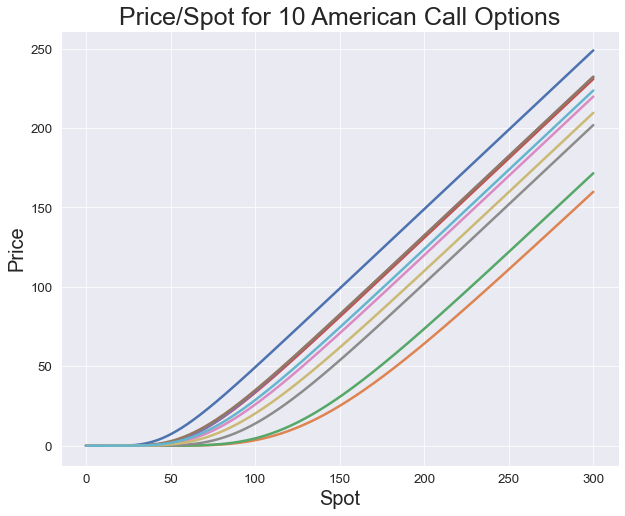

In [39]:
#@title Price/spot plot for the American Call options
# Prepare data for plotting 
options = [x + 1 for x in range(number_of_options) for _ in range(1024)]
plot_data = pd.DataFrame({
    'Spot': list(np.ndarray.flatten(grid_locations)) * number_of_options, 
    'Price': estimate.flatten(),
    'Option': options})


# Plot
plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plot = sns.lineplot(x="Spot", y="Price", hue="Option",
                    data=plot_data,
                    palette=sns.color_palette()[:number_of_options],
                    legend=False)
plot.axes.set_title(f"Price/Spot for {number_of_options} American Call Options",
                    fontsize=25)
xlabel = plot.axes.get_xlabel()
ylabel = plot.axes.get_ylabel()
plot.axes.set_xlabel(xlabel, fontsize=20)
plot.axes.set_ylabel(ylabel, fontsize=20)
plt.show()

### GPU Implementation

In [40]:
#@title Tensorflow Finance pricing on GPU

number_of_options = 10000  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = tf.float64

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

device = "/gpu:0"
with tf.device(device):
  
  # Warmup (graph construction + graph optimization)
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

  # Timed run
  t = time.time()
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)
  time_gpu = time.time() - t
    
gpu_options_per_second = number_of_options / time_gpu
print('------------------------')
print('Tensorflow GPU')
print('wall time: ', time_gpu)
print('options per second: ', gpu_options_per_second)
print('------------------------')

------------------------
Tensorflow GPU
wall time:  7.320438623428345
options per second:  1366.0383638756266
------------------------
